In [5]:
from pathlib import Path 
import pandas as pd 
import glob 
import numpy as np
import fastparquet as fpa 
import seaborn as sns 
import matplotlib.pyplot as plt 
import tqdm
from tqdm.notebook import tqdm
import gc 
from sklearn.preprocessing import MinMaxScaler 
import warnings 
warnings.filterwarnings('ignore')
import os


def calc_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])

def calc_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])

def calc_wap3(df):
    return (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2']+ df['ask_size2'])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))


def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)

    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum]
    }


    df_feature = df.groupby('time_id').agg(aggregate_dictionary)

    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    last_seconds = [300]

    for second in last_seconds:
        second = 600 - second
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')

        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)

    df_feature = df_feature.add_prefix("trade_")
    stock_id = file_path.split('/')[-2].split("=")[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    print(df_feature)

    return df_feature


def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)

    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap3'] = calc_wap3(df)
    df['log_return3'] = df.groupby('time_id')['wap3'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'log_return3':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
    }
    
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature    
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('/')[-2].split("=")[1]
    print(df_feature.head(10))
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)

    # print(df_feature)
    
    return df_feature

def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_v1 = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_book = file_path_v1 + "/" + os.listdir(file_path_v1)[0]
            file_path_v2 = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = file_path_v2 + "/" + os.listdir(file_path_v2)[0]
        else:
            # file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            # file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            file_path_v1 = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_book = file_path_v1 + "/" + os.listdir(file_path_v1)[0]
            file_path_v2 = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = file_path_v2 + "/" + os.listdir(file_path_v2)[0]
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

os.chdir("/home/champion/Desktop/competition/OptiverRealizedVolatilityPrediction/code")
data_dir = "../input/optiver-realized-volatility-prediction/"

train = pd.read_csv(data_dir + 'train.csv')
train_ids = train.stock_id.unique()
df_train = preprocessor(list_stock_ids=train_ids, is_train = True)
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

test = pd.read_csv(data_dir + 'test.csv')
df_test_ids = test.stock_id.unique()
df_test = preprocessor(list_stock_ids=df_test_ids, is_train = False)
df_test = test.merge(df_test, on = ['row_id'], how = 'left')


from sklearn.model_selection import KFold


df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])
stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_ext'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 77)
# 分10次，每一个时间段的值使用其他时段的平均值
for idx_1, idx_2 in tqdm(kf.split(df_train)):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_ext'] = tmp

# 特征和标签
df_train = df_train.reset_index(drop=True)
target = df_train['target']
df_train = df_train.drop(['target'],axis=1)
X = df_train
y = target

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


0it [00:00, ?it/s]

In [9]:
X.columns

Index(['row_id', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'log_return3_realized_volatility',
       'wap_balance_mean', 'price_spread_mean', 'bid_spread_mean',
       'ask_spread_mean', 'volume_imbalance_mean', 'total_volume_mean',
       'wap_mean', 'log_return_realized_volatility_450',
       'log_return2_realized_volatility_450',
       'log_return3_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap_mean_450',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300',
       'log_return3_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_150',
       'log_return2_realized_volatility_150'

In [12]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
best_lgb_params = {
 'metric': 'mae',
 'objective': 'regression'}
best_lgb_params["learning_rate"] = 0.005
best_lgb_params["early_stopping_round"] = 50  
best_lgb_params["max_depth"] = 100
best_lgb_params["num_iterations"] = 2500

import optuna 
import optuna.integration.lightgbm as lgbo

params = { 'objective': 'mean_squared_error', 'metric': 'rmse' }
from sklearn.metrics import mean_absolute_error

col = ['log_return_realized_volatility',
       'log_return2_realized_volatility', 'log_return3_realized_volatility',
       'wap_balance_mean', 'price_spread_mean', 'bid_spread_mean',
       'ask_spread_mean', 'volume_imbalance_mean', 'total_volume_mean',
       'wap_mean', 'log_return_realized_volatility_450',
       'log_return2_realized_volatility_450',
       'log_return3_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap_mean_450',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300',
       'log_return3_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_150',
       'log_return2_realized_volatility_150',
       'log_return3_realized_volatility_150', 'wap_balance_mean_150',
       'price_spread_mean_150', 'bid_spread_mean_150', 'ask_spread_mean_150',
       'volume_imbalance_mean_150', 'total_volume_mean_150', 'wap_mean_150',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_sum', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_sum_300','stock_id_target_ext'
]

x_train, x_test, y_train, y_test = train_test_split(X[col], y, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)

model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

# from sklearn.model_selection import train_test_split
# import lightgbm as lgb
# from sklearn.metrics import accuracy_score
# best_lgb_params = {
#  'metric': 'mae',
#  'objective': 'regression'}
# best_lgb_params["learning_rate"] = 0.005
# best_lgb_params["early_stopping_round"] = 50  
# best_lgb_params["max_depth"] = 100
# best_lgb_params["num_iterations"] = 2500


[I 2021-08-21 19:47:18,177] A new study created in memory with name: no-name-96ff6a74-49bb-40e1-993e-8605bf960d1c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001254:  14%|#4        | 1/7 [00:01<00:08,  1.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001254:  29%|##8       | 2/7 [00:02<00:06,  1.25s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001253:  43%|####2     | 3/7 [00:03<00:04,  1.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001253:  57%|#####7    | 4/7 [00:04<00:03,  1.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001253:  71%|#######1  | 5/7 [00:05<00:02,  1.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction, val_score: 0.001253:  86%|########5 | 6/7 [00:06<00:01,  1.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001252:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001245:   5%|5         | 1/20 [00:02<00:43,  2.29s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  10%|#         | 2/20 [00:04<00:40,  2.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  15%|#5        | 3/20 [00:06<00:32,  1.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  20%|##        | 4/20 [00:08<00:35,  2.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  25%|##5       | 5/20 [00:11<00:36,  2.45s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  30%|###       | 6/20 [00:13<00:29,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  35%|###5      | 7/20 [00:14<00:23,  1.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  40%|####      | 8/20 [00:16<00:22,  1.91s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  45%|####5     | 9/20 [00:18<00:20,  1.89s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  50%|#####     | 10/20 [00:19<00:18,  1.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  55%|#####5    | 11/20 [00:22<00:17,  1.97s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  60%|######    | 12/20 [00:24<00:16,  2.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  65%|######5   | 13/20 [00:26<00:14,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  70%|#######   | 14/20 [00:28<00:12,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  75%|#######5  | 15/20 [00:30<00:10,  2.08s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  80%|########  | 16/20 [00:33<00:08,  2.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  85%|########5 | 17/20 [00:35<00:06,  2.06s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  90%|######### | 18/20 [00:37<00:04,  2.15s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


num_leaves, val_score: 0.001243:  95%|#########5| 19/20 [00:39<00:02,  2.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  10%|#         | 1/10 [00:02<00:19,  2.17s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  20%|##        | 2/10 [00:03<00:14,  1.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  30%|###       | 3/10 [00:06<00:14,  2.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  40%|####      | 4/10 [00:08<00:13,  2.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  50%|#####     | 5/10 [00:11<00:11,  2.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  60%|######    | 6/10 [00:13<00:09,  2.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  70%|#######   | 7/10 [00:15<00:06,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  80%|########  | 8/10 [00:17<00:04,  2.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


bagging, val_score: 0.001243:  90%|######### | 9/10 [00:20<00:02,  2.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:  17%|#6        | 1/6 [00:02<00:11,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:  33%|###3      | 2/6 [00:04<00:09,  2.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:  50%|#####     | 3/6 [00:07<00:07,  2.46s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:  67%|######6   | 4/6 [00:09<00:04,  2.34s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


feature_fraction_stage2, val_score: 0.001243:  83%|########3 | 5/6 [00:11<00:02,  2.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:   5%|5         | 1/20 [00:02<00:50,  2.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:  10%|#         | 2/20 [00:06<00:58,  3.27s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:  15%|#5        | 3/20 [00:09<00:54,  3.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:  20%|##        | 4/20 [00:13<00:58,  3.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:  25%|##5       | 5/20 [00:16<00:50,  3.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001243:  30%|###       | 6/20 [00:20<00:48,  3.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

regularization_factors, val_score: 0.001243:  35%|###5      | 7/20 [00:23<00:42,  3.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

regularization_factors, val_score: 0.001243:  40%|####      | 8/20 [00:24<00:32,  2.74s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.001240:  45%|####5     | 9/20 [00:27<00:29,  2.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001240:  50%|#####     | 10/20 [00:30<00:26,  2.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001238:  55%|#####5    | 11/20 [00:32<00:23,  2.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001238:  60%|######    | 12/20 [00:35<00:21,  2.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001237:  65%|######5   | 13/20 [00:40<00:23,  3.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

regularization_factors, val_score: 0.001237:  70%|#######   | 14/20 [00:43<00:19,  3.28s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001237:  75%|#######5  | 15/20 [00:46<00:15,  3.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

regularization_factors, val_score: 0.001237:  80%|########  | 16/20 [00:47<00:10,  2.55s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.001237:  85%|########5 | 17/20 [00:50<00:07,  2.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


regularization_factors, val_score: 0.001237:  90%|######### | 18/20 [00:52<00:05,  2.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

regularization_factors, val_score: 0.001237:  95%|#########5| 19/20 [00:55<00:02,  2.59s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


min_data_in_leaf, val_score: 0.001237:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.001236:  20%|##        | 1/5 [00:02<00:11,  2.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


min_data_in_leaf, val_score: 0.001236:  40%|####      | 2/5 [00:05<00:08,  2.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

min_data_in_leaf, val_score: 0.001235:  60%|######    | 3/5 [00:08<00:05,  2.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883


min_data_in_leaf, val_score: 0.001235:  80%|########  | 4/5 [00:11<00:02,  2.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 300252, number of used features: 49
[LightGBM] [Info] Start training from score 0.003883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.001235: 100%|##########| 5/5 [00:14<00:00,  2.81s/it]


{'objective': 'mean_squared_error',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 0.09009527991526155,
 'lambda_l2': 1.1671420872462157e-08,
 'num_leaves': 190,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 100,
 'early_stopping_round': 5}

In [13]:
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.005
best_lgb_params["early_stopping_round"] = 200
best_lgb_params["num_iterations"] = 80000

from sklearn.model_selection import KFold
kf = KFold(n_splits=8, random_state=77, shuffle=True)
oof = pd.DataFrame()               
models = []                          
scores = 0.0  

In [14]:
X['stock_id'] =X['stock_id'].astype(int)
df_test['stock_id'] =df_test['stock_id'].astype(int)
df_test['time_id']  =df_test['time_id'].astype(int)

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

In [15]:
import lightgbm as lgbm
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X[col].loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X[col].loc[val_idx], y[val_idx]

    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    

    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100 #,
                      #categorical_feature = ['stock_id','time_id']                
                     )

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)


Fold : 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12494
[LightGBM] [Info] Number of data points in the train set: 375315, number of used features: 49
[LightGBM] [Info] Start training from score 0.001798
[100]	training's rmse: 0.000490894	training's RMSPE: 0.2273	valid_1's rmse: 0.000503365	valid_1's RMSPE: 0.23218
[200]	training's rmse: 0.000480592	training's RMSPE: 0.22253	valid_1's rmse: 0.000500298	valid_1's RMSPE: 0.23077
[300]	training's rmse: 0.000473621	training's RMSPE: 0.2193	valid_1's rmse: 0.000499162	valid_1's RMSPE: 0.23024
[400]	training's rmse: 0.000467848	training's RMSPE: 0.21663	valid_1's rmse: 0.000498781	valid_1's RMSPE: 0.23007
[500]	training's rmse: 0.000462721	training's RMSPE: 0.21426	valid_1's rmse: 0.000498587	valid_1's RMSPE: 0.22998
[600]	training's rmse: 0.000457994	training's RMSPE: 0.21207	valid_1's rmse:

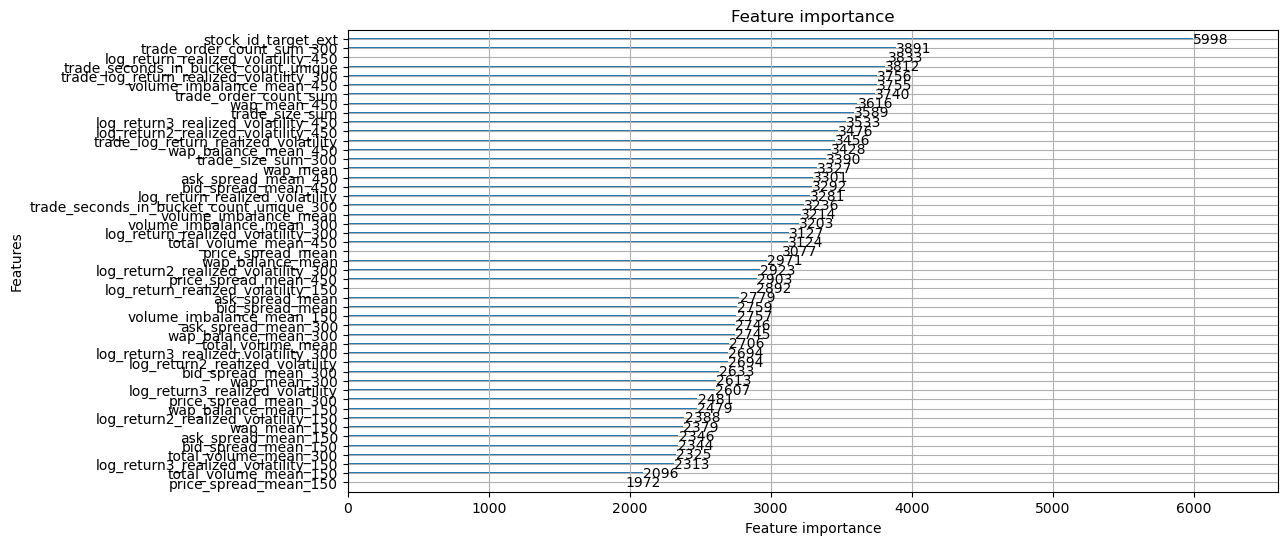

In [16]:
lgbm.plot_importance(model, figsize=(12, 6))
plt.show()